# NYC Taxi - Data exploration and cleaning

This notebook solves the following activities:

- Download and assess the data
- Identify and document any issues with the data
- Document how you resolved these issues

Data sources:

- Yellow Taxi Trip Records: 
    - Description: Data about yellow taxis in NYC, that includes 
      include fields capturing pick-up and drop-off dates/times, 
      pick-up and drop-off locations, trip distances
    - URL: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page    
    - Data dictionary: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

- Taxi Zone Lookup Table:
    - Description: Table that groups different zones in NYC
    - URL: https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv

- Taxi Zone Shapefile:
    - Description: Shepefile with the geographic polygons of the zones in NYC
    - URL: https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip



In [1]:
import extraction
import importlib
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
import yaml
import matplotlib.pyplot as plt

with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

## STEP 1: Extract data

In [2]:
importlib.reload(extraction)

spark = SparkSession \
    .builder \
    .appName("NYC Taxi") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled","true")        

psdf_taxi = extraction.get_taxi_data(spark, cfg)
df_zones = extraction.get_zones(cfg)
gdf_zones_shp = extraction.get_zones_shapefile(cfg)

In [ ]:
psdf_taxi = psdf_taxi.sample(0.01)
# psdf_taxi.sample(0.01).count()

In [ ]:
psdf_taxi = psdf_taxi.withColumn('duration_in_min', 
    func.round((psdf_taxi["tpep_dropoff_datetime"].cast("long") 
    - psdf_taxi["tpep_pickup_datetime"].cast("long"))/60,1))

In [ ]:
psdf_taxi.select(["passenger_count", "trip_distance", "RatecodeID", \
    "duration_in_min", "payment_type", "fare_amount", "extra"]).describe().show()

psdf_taxi.select(["MTA_tax", "Improvement_surcharge", "tip_amount", "tolls_amount",\
    "total_amount", "Congestion_Surcharge", "Airport_fee"]).describe().show()

psdf_taxi.select(["VendorID", "RateCodeID", "Store_and_fwd_flag", \
    "Payment_type"]).describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|summary|   passenger_count|     trip_distance|        RatecodeID|   duration_in_min|       payment_type|       fare_amount|              extra|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|  count|           1134572|           1134572|           1134572|           1134572|            1134572|           1134572|            1134572|
|   mean|1.6249325736929874|2.9253940781193104|1.0436093963186117|16.583745147950097| 1.3367269772213664|12.966696110956388|0.33150173810035855|
| stddev|1.2636690461482993|3.7392711688690765|0.5238976607419272| 56.87353530407632|0.49315474815197036|11.775091126871317| 0.4580496818886134|
|    min|                 0|               0.0|                 1|             -56.9|                  1|            -308.0|      

In [ ]:
# from below table we can see some negative values which might be errors

count = psdf_taxi.count()

count_chash = psdf_taxi.filter(psdf_taxi.payment_type == 2).count()
print(f"Num rows with cash: {count_chash} ({round(100*count_chash/count,2)}%)")

count_passanger_0 = psdf_taxi.filter(psdf_taxi.passenger_count == 0).count()
print(f"Num rows with passanger 0: {count_passanger_0} ({round(100*count_passanger_0/count,2)}%)")

count_trip_distance_0 = psdf_taxi.filter(psdf_taxi.trip_distance == 0).count()
print(f"Num rows with distance 0: {count_trip_distance_0} ({round(100*count_trip_distance_0/count,2)}%)")

count_fare_amount_below0 = psdf_taxi.filter(psdf_taxi.fare_amount <= 0).count()
print(f"Num rows with fare amount <= 0: {count_fare_amount_below0} ({round(100*count_fare_amount_below0/count,2)}%)")

count_extra_below0 = psdf_taxi.filter(psdf_taxi.extra < 0).count()
print(f"Num rows with extra < 0 : {count_extra_below0} ({round(100*count_extra_below0/count,2)}%)")

count_extra_not_mod_05 = psdf_taxi.filter(psdf_taxi.extra % 0.5 != 0).count()
print(f"Num rows with extra not mod 0.5 : {count_extra_not_mod_05} ({round(100*count_extra_not_mod_05/count,2)}%)")

# we accept 0 or 0.5 MTA Tax, althought always should be 0
count_MTA_tax_not05 = psdf_taxi.filter(~psdf_taxi.mta_tax.isin([0, 0.5])).count()
print(f"Num rows with MTA_tax != 0.5: {count_MTA_tax_not05} ({round(100*count_MTA_tax_not05/count,2)}%)")

count_improvement_surcharge_not_valid = psdf_taxi.filter(psdf_taxi.improvement_surcharge != 0.3).count()
print(f"Num rows with improvement_surcharge != 0.3: {count_improvement_surcharge_not_valid} ({round(100*count_improvement_surcharge_not_valid/count,2)}%)")

count_total_amount_below0 = psdf_taxi.filter(psdf_taxi.total_amount <= 0).count()
print(f"Num rows with total amount <= 0 : {count_total_amount_below0} ({round(100*count_total_amount_below0/count,2)}%)")

count_tip_amount_below0 = psdf_taxi.filter(psdf_taxi.tip_amount < 0).count()
print(f"Num rows with tip amount < 0 : {count_tip_amount_below0} ({round(100*count_tip_amount_below0/count,2)}%)")

count_RateCodeID_not_valid = psdf_taxi.filter((psdf_taxi["RateCodeID"]<1) | (psdf_taxi["RateCodeID"]>6)).count()
print(f"Num rows with RateCodeID not between 1 and 6: {count_RateCodeID_not_valid} ({round(100*count_RateCodeID_not_valid/count,2)}%)")

psdf_taxi = psdf_taxi.withColumn('sum_amount', \
        func.round(psdf_taxi.tip_amount + psdf_taxi.fare_amount + psdf_taxi.extra + \
        psdf_taxi.mta_tax + psdf_taxi.improvement_surcharge + \
        psdf_taxi.tolls_amount, 2))

count_sum_not_valid = psdf_taxi.filter(psdf_taxi["sum_amount"] != psdf_taxi["total_amount"]).count()
print(f"Num rows with total sum amount not valid: {count_sum_not_valid} ({round(100*count_sum_not_valid/count,2)}%)")

count_pickup_after_dropoff = psdf_taxi.filter(psdf_taxi["tpep_pickup_datetime"] >= psdf_taxi["tpep_dropoff_datetime"]).count()
print(f"Num rows with pickup time >= dropoff : {count_pickup_after_dropoff} ({round(100*count_pickup_after_dropoff/count,2)}%)")

psdf_taxi = psdf_taxi.withColumn('pu_month', func.month(psdf_taxi.tpep_pickup_datetime))
psdf_taxi = psdf_taxi.withColumn('pu_year', func.year(psdf_taxi.tpep_pickup_datetime))
psdf_taxi = psdf_taxi.withColumn('do_month', func.month(psdf_taxi.tpep_dropoff_datetime))
psdf_taxi = psdf_taxi.withColumn('do_year', func.year(psdf_taxi.tpep_dropoff_datetime))
count_year_not_valid = psdf_taxi.filter(
        (~psdf_taxi["do_year"].isin(cfg["extraction"]["yellow_taxi"]["years"]))
        & (~psdf_taxi["pu_year"].isin(cfg["extraction"]["yellow_taxi"]["years"]))).count()
        
print(f"Num rows with year not valid: {count_year_not_valid} ({round(100*count_year_not_valid/count,2)}%)")

count_month_not_valid = psdf_taxi.filter(
        (~psdf_taxi["do_month"].isin(cfg["extraction"]["yellow_taxi"]["months"])) 
        & (~psdf_taxi["pu_month"].isin(cfg["extraction"]["yellow_taxi"]["months"]))).count()
        
print(f"Num rows with month not valid: {count_month_not_valid} ({round(100*count_month_not_valid/count,2)}%)")


# drop cash payments since we don't have tip information
# psdf_taxi = psdf_taxi.filter(psdf_taxi.payment_type != 2)


Num rows with cash: 36480607 (32.14%)
Num rows with passanger 0: 166087 (0.15%)
Num rows with distance 0: 743185 (0.65%)
Num rows with fare amount <= 0: 89994 (0.08%)
Num rows with extra < 0 : 27488 (0.02%)
Num rows with extra not mod 0.5 : 4252 (0.0%)
Num rows with MTA_tax != 0.5: 57684 (0.05%)
Num rows with improvement_surcharge != 0.3: 88640 (0.08%)
Num rows with total amount <= 0 : 70282 (0.06%)
Num rows with tip amount < 0 : 844 (0.0%)
Num rows with RateCodeID not between 1 and 6: 2970 (0.0%)
Num rows with total sum amount not valid: 195239 (0.17%)


In [ ]:
df_basic_stats = psdf_taxi.sample(0.06).select(
    ['duration_in_min', 'passenger_count', 'fare_amount',
    'tip_amount', 'tolls_amount', 'trip_distance']).toPandas() 


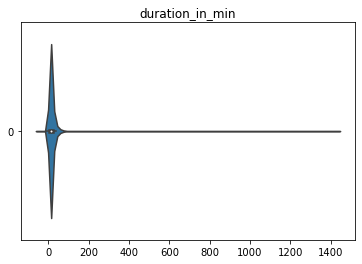

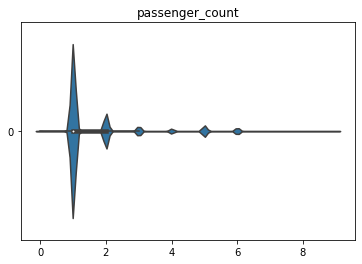

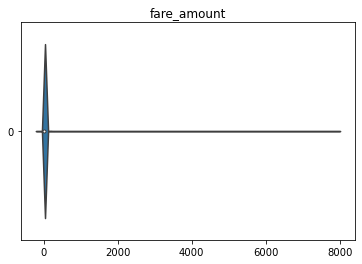

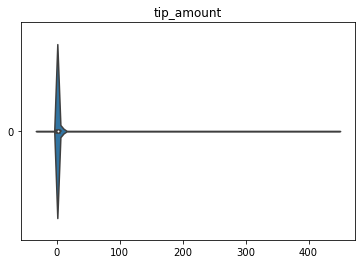

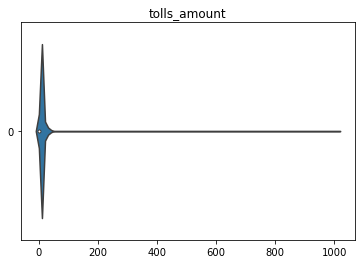

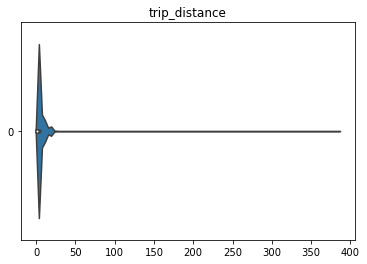

In [ ]:
ax = sns.violinplot(data=df_basic_stats['duration_in_min'], orient='h')
ax.set_title(f"duration_in_min")
plt.show()
ax = sns.violinplot(data=df_basic_stats['passenger_count'], orient='h')
ax.set_title(f"passenger_count")
plt.show()
ax = sns.violinplot(data=df_basic_stats['fare_amount'], orient='h')
ax.set_title(f"fare_amount")
plt.show()
ax = sns.violinplot(data=df_basic_stats['tip_amount'], orient='h')
ax.set_title(f"tip_amount")
plt.show()
ax = sns.violinplot(data=df_basic_stats['tolls_amount'], orient='h')
ax.set_title(f"tolls_amount")
plt.show()
ax = sns.violinplot(data=df_basic_stats['trip_distance'], orient='h')
ax.set_title(f"trip_distance")
plt.show()

In [ ]:
# we can see a right-skewed distribution with extremely large values
# for the variables duration_in_min, fare_amount, tip_amount, tolls_amount
# that are probably errors. So we can apply the Mean and 
# Standard Deviation Method to remove outliers for maximum values
vars_to_remove_outliers = ['duration_in_min', 'fare_amount', 
    'tip_amount', 'tolls_amount', 'trip_distance']

for var_remove in vars_to_remove_outliers:
    df_stats = psdf_taxi.select(
        func.mean(func.col(var_remove)).alias('mean'),
        func.stddev(func.col(var_remove)).alias('std'),
        func.max(func.col(var_remove)).alias('max')
    ).collect()

    mean = df_stats[0]['mean']
    std = df_stats[0]['std']
    max = df_stats[0]['max']    
    max_outlier = mean + 3 * std
    print(f"""mean {var_remove}:{mean} std:{std} max:{max} 
        threshold:{round(max_outlier,1)}""")

    count_outlier = psdf_taxi.filter(psdf_taxi[var_remove] > max_outlier).count()
    print(f"Num outliers: {count_outlier} ({round(100*count_outlier/count,2)}%)")
# this outlier detection method is enough to discard extremely large values
# which probably are errors. Other methods like IQR would remove trips with a few
# hours of duration, which can be feasible.
# With this method, we will remove trips above 7h, which is 0.18%. 
# That results make sense for this domain.

mean duration_in_min:17.029848539722977 std:186.25368249137108 max:575.8
Num outliers: 66926 (0.17%)
mean fare_amount:13.066570185603247 std:142.70154189589294 max:441.2
Num outliers: 239 (0.0%)
mean tip_amount:1.8593100368888438 std:2.6343942239584357 max:9.8
Num outliers: 909945 (2.35%)
mean tolls_amount:0.32555074883020624 std:1.9396839512374882 max:6.1
Num outliers: 128361 (0.33%)
mean trip_distance:2.900209770426959 std:4.291890349759443 max:15.8
Num outliers: 1020779 (2.63%)


In [ ]:
psdf_taxi = psdf_taxi.withColumn('pu_month', func.month(psdf_taxi.tpep_pickup_datetime))
psdf_taxi = psdf_taxi.withColumn('pu_year', func.year(psdf_taxi.tpep_pickup_datetime))
psdf_taxi = psdf_taxi.withColumn('do_month', func.month(psdf_taxi.tpep_dropoff_datetime))
psdf_taxi = psdf_taxi.withColumn('do_year', func.year(psdf_taxi.tpep_dropoff_datetime))

count_year_not_valid = psdf_taxi.filter((
        ~psdf_taxi["do_year"].isin(cfg["extraction"]["yellow_taxi"]["years"])) 
        & ~psdf_taxi["pu_year"].isin(cfg["extraction"]["yellow_taxi"]["years"])).count()

count_year_not_valid

10148

In [ ]:
print(f"Duplicated zone IDs? {(df_zones['LocationID'].duplicated().any())}")
print(f"Duplicated zone shp IDs? {(gdf_zones_shp['LocationID'].duplicated().any())}")
print(f"Duplicated zone shp OBJECTIDs? {(gdf_zones_shp['OBJECTID'].duplicated().any())}")

# we can see that LocationID in SHP has duplicates
print(gdf_zones_shp[gdf_zones_shp['LocationID'].duplicated()][['LocationID', 'OBJECTID']])

# these duplicates coincide with the non related rows with columns OBJECTID and LocationID
print(gdf_zones_shp[gdf_zones_shp['LocationID'] != gdf_zones_shp['OBJECTID']][['LocationID', 'OBJECTID']])

# so we can conclude that we should user OBJECTID instead for SHP dataframe

Duplicated zone IDs? False
Duplicated zone shp IDs? True
Duplicated zone shp OBJECTIDs? False
     LocationID  OBJECTID
56           56        57
103         103       104
104         103       105
     LocationID  OBJECTID
56           56        57
103         103       104
104         103       105


<AxesSubplot:>

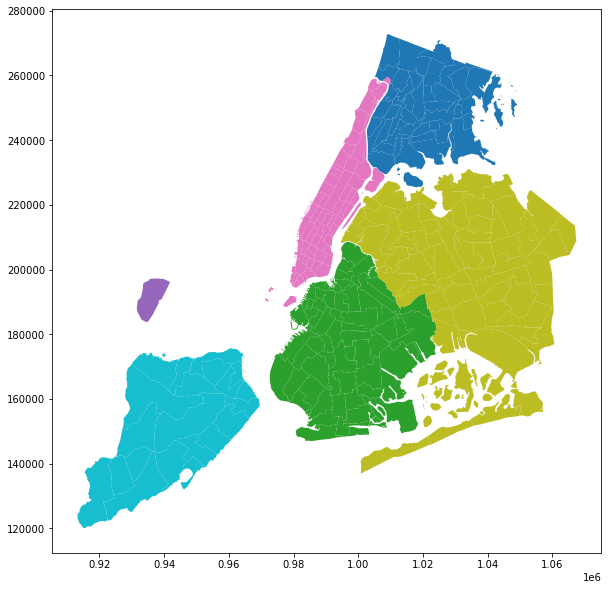

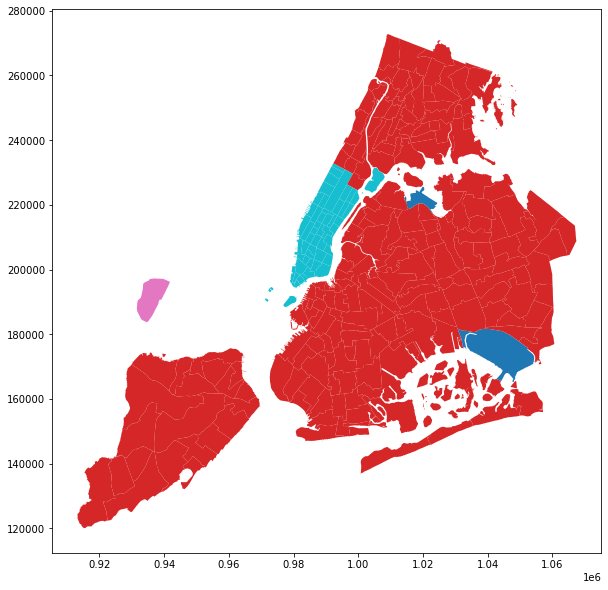

In [ ]:
gdf_zones_shp_cp = gdf_zones_shp.merge(
    df_zones[["LocationID", "service_zone"]],
    left_on="OBJECTID", 
    right_on="LocationID")

gdf_zones_shp_cp = gdf_zones_shp_cp.reset_index(drop=True)
gdf_zones_shp_cp.plot(column="borough", figsize=(15, 10),)
gdf_zones_shp_cp.plot(column="service_zone", figsize=(15, 10),)